<a href="https://colab.research.google.com/github/Rogerio-mack/BIG_DATA_Analytics_Mineracao_e_Analise_de_Dados/blob/main/BIG_T4_Knn_CV_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->


# **4. K-Vizinhos Mais Próximos, Validação Cruzada e *GridSearch***
---

Nesta trilha você vai aprender:

* O Modelo de Classificação K-Vizinhos Mais Próximos
* Conjunto de Validação e Teste, e como aplicar a Validação Cruzada de Dados
* Como selecionar melhores hiperparâmetros dos Modelos

Nesta e na próxima trilha vamos nos deter unicamente em modelos para classificação de dados e aqui vamos explorar um único modelo, o de K-Vizinhos Mais Próximos. A partir de um problema bastante simples vamos incrementar esse modelo para que você possa explorar seus conceitos, mas também vários outros conceitos e técnicas de uso geral no aprendizado de máquina e classificadores, como o emprego de estimadores para normalização e encode, conjuntos de validação e teste, validação cruzada e seleção de hiperparâmetros.




In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import seaborn as sns

# K-Vizinhos Mais Próximos

O K-Vizinhos mais Próximos, ou Knn (do inglês, K nearest neighbors) é um dos modelos mais simples de classificação, mas também bastante empregado. Seu funcionamento se baseia em um princípio muito simples que nós mesmos adotamos frequentemente no dia a dia, nós, por exemplo, nos assemelhamos às pessoas mais próximas de nós. Assim, é razoável supor que podemos classificar uma instância de acordo com a classe de seus vizinhos mais próximos.

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


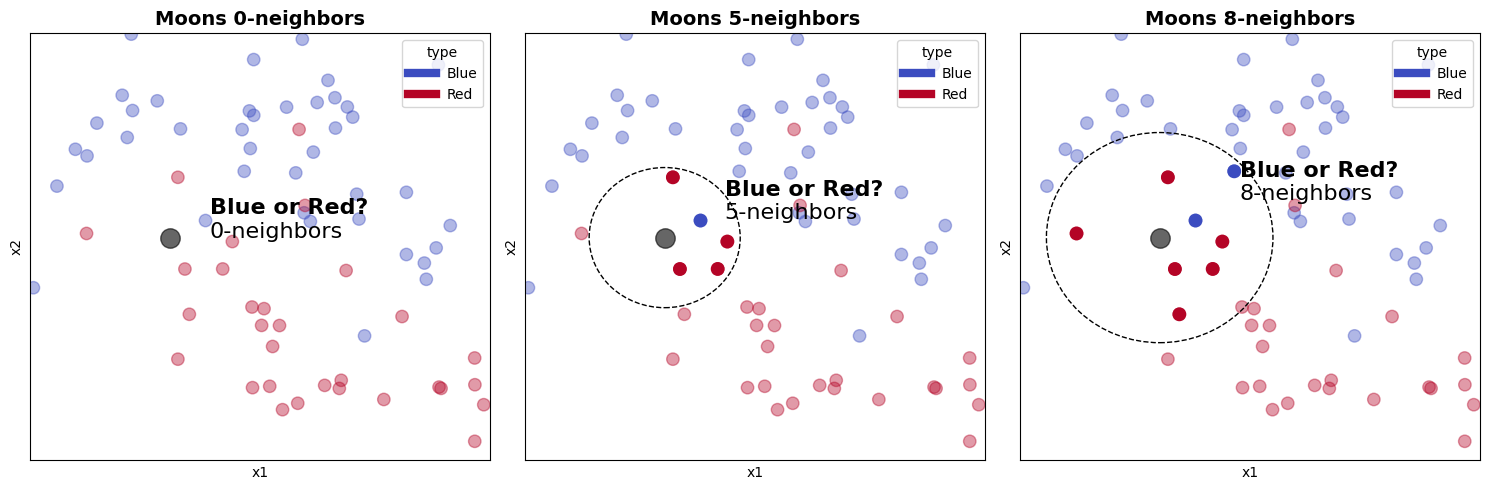

In [48]:
# you can skip this code!

from sklearn.datasets import make_moons
from sklearn.neighbors import DistanceMetric
cmap_data = plt.cm.coolwarm

X, y = make_moons(n_samples=100, noise=0.25, random_state=1234)
moons = pd.DataFrame({'x1':X[:, 0], 'x2':X[:, 1], 'y':y})

X, y = make_moons(n_samples=1, noise=0.25, random_state=123)
# amoon = pd.DataFrame({'x1':X[:, 0], 'x2':X[:, 1], 'y':y})
amoon = pd.DataFrame({'x1':[-.2], 'x2':[.3]})

dist = DistanceMetric.get_metric('euclidean')
moons['distance'] = dist.pairwise(moons[['x1','x2']],amoon[['x1','x2']])

f, ax = plt.subplots(1,3,figsize=(15,5))
cmap_data = plt.cm.coolwarm

for i in range(3):
  neighbors = moons.nsmallest([0,5,8][i],'distance')
  ax[i].scatter(moons.x1, moons.x2, c=moons.y, cmap=cmap_data, alpha=0.4, s=80)
  ax[i].scatter(neighbors.x1, neighbors.x2, c=neighbors.y, cmap=cmap_data, s=80)
  ax[i].plot(amoon.x1, amoon.x2, 'ko', markersize=14, alpha=0.6)

  a_circle = plt.Circle((amoon.x1, amoon.x2), neighbors.distance.max()+0.05, edgecolor='k', linestyle='dashed',fill=False)
  ax[i].add_artist(a_circle)

  ax[i].text(amoon.x1+0.2+i/10, amoon.x2+i/10,'Blue or Red?\n', weight='bold', fontsize=16)
  ax[i].text(amoon.x1+0.2+i/10, amoon.x2+i/10,' \n' + str([0,5,8][i]) + '-neighbors', fontsize=16)
  ax[i].set_title('Moons ' + str([0,5,8][i]) + '-neighbors',weight='bold',fontsize=14)
  ax[i].set_xlabel("x1")
  ax[i].set_ylabel("x2")

  custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                  Line2D([0], [0], color=cmap_data(1.), lw=6)]
  ax[i].legend(custom_lines, ['Blue', 'Red'], loc='upper right',title='type')

  ax[i].set_xlim([-0.9,1.4])
  ax[i].set_ylim([-0.9,1.4])
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  # ax[i].axis('equal')

plt.tight_layout()
plt.show()


O número k define quantos vizinhos queremos empregar na classificação. No exemplo acima, considerando 5 vizinhos, você pode verificar que há uma chance de $4/5$ de que a moon *cinza* seja uma moon *red*, e com 8 vizinhos a chance é de $6/8 = 3/4$ de ser *red*. Assim, assumimos nos dois casos a classe *red* para prever a classe do ponto selecionado.

## Knn *by scratch*

O conceito do Knn é bastante simples o que permite implementar o algoritmo e verificar o seu funcionamento sem qualquer API ou pacote adicional. Basicamente o modelo consiste na execução de 3 passos:

1. Calcular as distâncias do elemento desejado para os demais
2. Encontrar os k-vizinhos mais próximos
3. Retornar a classe mais frequente entre dos k-vizinhos

O exemplo a seguir é um *exemplo de brinquedo* e foi livremente adaptado de [Sayad (2021)](https://www.saedsayad.com/data_mining_map.htm). A ideia é prever, com base na  idade, valor e retorno de empréstimos realizados anteriormente, a possibilidade de fazermos um bom ou mal empréstimo para um novo caso que desejamos avaliar.

In [49]:
loans = pd.DataFrame({'age':[25,35,45,20,35,52,23,40,60,48,33],
                      'loan':[40000,60000,80000,20000,120000,18000,95000,62000,100000,220000,150000],
                      'default':[1,1,1,1,1,1,0,0,0,0,0] }) # 1='yes'

case  = pd.DataFrame({'age':[47],'loan':[142000]})

display(loans)
display(case)

,age,loan,default
0,25,40000,1
1,35,60000,1
2,45,80000,1
3,20,20000,1
4,35,120000,1
5,52,18000,1
6,23,95000,0
7,40,62000,0
8,60,100000,0
9,48,220000,0


,age,loan
0,47,142000


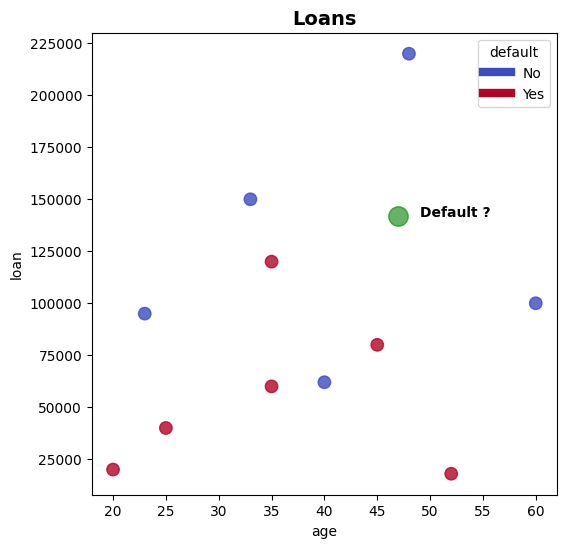

In [50]:
f, ax = plt.subplots(1,1,figsize=(6,6))
cmap_data = plt.cm.coolwarm

ax.scatter(loans.age, loans.loan, c=loans.default, cmap=cmap_data, alpha=0.8, s=80)
ax.plot(case.age, case.loan, 'go', markersize=14, alpha=0.6)

plt.text(case.age+2, case.loan,'Default ?', weight='bold')
plt.title('Loans',weight='bold',fontsize=14)
plt.xlabel("age")
plt.ylabel("loan")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6)]
plt.legend(custom_lines, ['No', 'Yes'], loc='upper right',title='default')

plt.show()


*Default* representa os casos em que o empréstimo não foi pago e, portanto, uma operação ruim. E nosso objetivo é prever, com base no conjunto de treinamento, qual classe (*Default Yes* ou *No*) de um novo empréstimo de $142.000$ para um cliente com $47$ anos.

Você pode, então, calcular diretamente a distância do par $(47, 142.000)$ para todos os demais dados e, na sequência, ordenar os dados para identificar os k-vizinhos mais próximos e a classe mais frenquente dentre eles. Aqui empregamos $k=3$ vizinhos mais próximos.

In [51]:
from sklearn.neighbors import DistanceMetric

dist = DistanceMetric.get_metric('euclidean')
d = dist.pairwise(loans[['age','loan']],case[['age','loan']])

loans['distance'] = d
display(loans.sort_values('distance'))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


,age,loan,default,distance
10,33,150000,0,8000.012250
4,35,120000,1,22000.003273
8,60,100000,0,42000.002012
6,23,95000,0,47000.006128
2,45,80000,1,62000.000032
9,48,220000,0,78000.000006
7,40,62000,0,80000.000306
1,35,60000,1,82000.000878
0,25,40000,1,102000.002373
3,20,20000,1,122000.002988


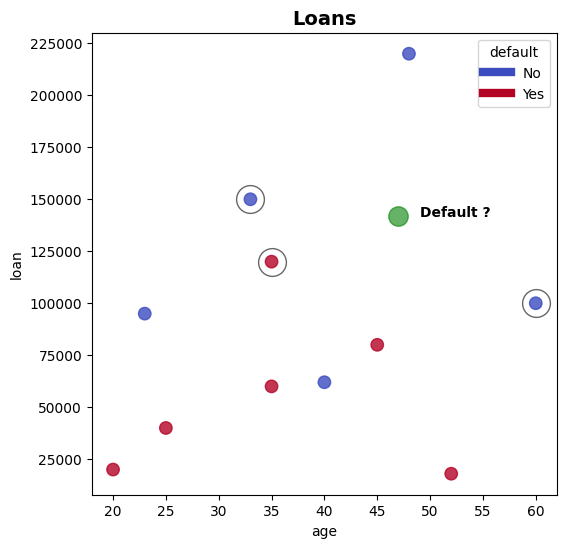

,age,loan,default,distance
10,33,150000,0,8000.012250
4,35,120000,1,22000.003273
8,60,100000,0,42000.002012


In [52]:
k3_neighbors = loans.nsmallest(3,'distance')

f, ax = plt.subplots(1,1,figsize=(6,6))
cmap_data = plt.cm.coolwarm

ax.scatter(k3_neighbors.age, k3_neighbors.loan, edgecolors='k', c='w', alpha=0.6, s=400)
ax.scatter(loans.age, loans.loan, c=loans.default, cmap=cmap_data, alpha=0.8, s=80)
ax.plot(case.age, case.loan, 'go', markersize=14, alpha=0.6)

plt.text(case.age+2, case.loan,'Default ?', weight='bold')
plt.title('Loans',weight='bold',fontsize=14)
plt.xlabel("age")
plt.ylabel("loan")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6)]
plt.legend(custom_lines, ['No', 'Yes'], loc='upper right',title='default')

plt.show()

display(k3_neighbors)

Com base nisso podemos estimar que a classe desse empréstimo é *Default No* (zeros) com probabilidade de $2/3$ e, portanto, deveríamos conceder o empréstimo.

## Revisando o Modelo: Normalizando os Dados

O cálculo de distâncias como medida de similaridade (menor distância indicando maior similaridade) pode, entretanto, apresentar grandes desvios quando empregamos variáveis ​com escalas muito diferentes ou variáveis ​​numéricas e categóricas em conjunto.

Veja que no nosso exemplo os valores dos empréstimos encontram-se em uma escala de valores $1000$ vezes maior que a idade e, por isso, idade teve pouca ou nenhuma influência nas distâncias e poderíamos ter o mesmo resultado empregando somente o os valores dos empréstimos.

> Vários modelos de aprendizado de máquina são baseados em distância como medida de similaridade e são portanto *sensíveis* à normalização dos dados e devemos aplicá-la quando empregados dados em diferentes escalas.


In [53]:
dist = DistanceMetric.get_metric('euclidean')
d = dist.pairwise(loans[['loan']],case[['loan']])

loans['distance_loans'] = d
display(loans.sort_values('distance'))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


,age,loan,default,distance,distance_loans
10,33,150000,0,8000.012250,8000.0
4,35,120000,1,22000.003273,22000.0
8,60,100000,0,42000.002012,42000.0
6,23,95000,0,47000.006128,47000.0
2,45,80000,1,62000.000032,62000.0
9,48,220000,0,78000.000006,78000.0
7,40,62000,0,80000.000306,80000.0
1,35,60000,1,82000.000878,82000.0
0,25,40000,1,102000.002373,102000.0
3,20,20000,1,122000.002988,122000.0


A maior escala dos valores de `loan` faz com que o '*peso*' dessa variável no cálculo das distâncias praticamente '*anule*' a importância da variável *age*.

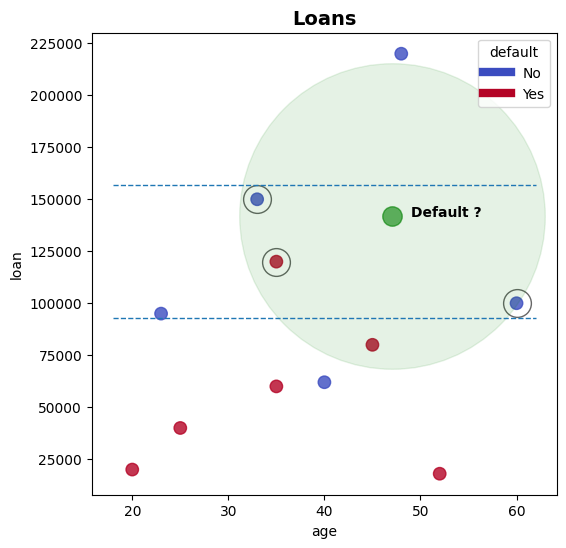

,age,loan,default,distance
10,33,150000,0,8000.012250
4,35,120000,1,22000.003273
8,60,100000,0,42000.002012


In [54]:
f, ax = plt.subplots(1,1,figsize=(6,6))
cmap_data = plt.cm.coolwarm

ax.plot(case.age, case.loan, 'go', markersize=220, alpha=0.10)
ax.scatter(k3_neighbors.age, k3_neighbors.loan, edgecolors='k', c='w', alpha=0.6, s=400)
ax.scatter(loans.age, loans.loan, c=loans.default, cmap=cmap_data, alpha=0.8, s=80)
ax.plot(case.age, case.loan, 'go', markersize=14, alpha=0.6)

plt.hlines(157000,18,62,linestyles='dashed',lw=1)
plt.hlines(93000,18,62,linestyles='dashed',lw=1)

plt.text(case.age+2, case.loan,'Default ?', weight='bold')
plt.title('Loans',weight='bold',fontsize=14)
plt.xlabel("age")
plt.ylabel("loan")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6)]
plt.legend(custom_lines, ['No', 'Yes'], loc='upper right',title='default')

plt.show()

display(k3_neighbors)

 A solução é normalizar os dados do conjunto de treinamento. Existem várias técnicas de normalização e aqui vamos empregar a normalização *min_max* que leva todos os valores ao intervalo $[0,1]$.

### Normalização com `scikit-learn`: Função *vs* Estimador

Você pode simplesmente empregar uma função `minmax_scale` do `scikit-learn` para fazer a normalização e existem outras funções para os demais tipos de normalização.

In [55]:
from sklearn.preprocessing import minmax_scale

minmax_scale(loans[['age','loan']])

array([[0.125     , 0.10891089],
       [0.375     , 0.20792079],
       [0.625     , 0.30693069],
       [0.        , 0.00990099],
       [0.375     , 0.5049505 ],
       [0.8       , 0.        ],
       [0.075     , 0.38118812],
       [0.5       , 0.21782178],
       [1.        , 0.40594059],
       [0.7       , 1.        ],
       [0.325     , 0.65346535]])

Mas o uso de funções não permite aplicarmos a mesma regra de normalização em outros conjuntos de dados!

In [56]:
minmax_scale(case)

array([[0., 0.]])

Neste caso, é melhor empregarmos um *estimador* do `scikit-learn`. O cálculo é o mesmo da função `minmaxscaler`, mas o uso de um estimador permite salvarmos os parâmetros empregados para a mesma aplicação em outros conjuntos de dados.

> *Na normalização de dados com o `scikit-learn` é preferível uso de estimadores no lugar de funções para que a mesma transformação possa ser efetuada em outros conjuntos de dados. O mesmo princípio se aplica a outras transformações, como os encodes.*

Vamos então aplicar o estimador `MinMaxScaler` no lugar da função.

In [57]:
# apenas mostrando o resultado do estimador
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
print(scaler.fit(loans[['age','loan']]))

print(scaler.data_max_)

print(scaler.transform(loans[['age','loan']]))
print(scaler.transform(case))

MinMaxScaler()
[6.0e+01 2.2e+05]
[[0.125      0.10891089]
 [0.375      0.20792079]
 [0.625      0.30693069]
 [0.         0.00990099]
 [0.375      0.5049505 ]
 [0.8        0.        ]
 [0.075      0.38118812]
 [0.5        0.21782178]
 [1.         0.40594059]
 [0.7        1.        ]
 [0.325      0.65346535]]
[[0.675      0.61386139]]


In [58]:
# criando os dados normalizados, 'scaled'
loans_scaled = pd.DataFrame(scaler.transform(loans[['age','loan']]),columns=loans.columns[0:2])
loans_scaled = pd.concat([loans_scaled,loans[['default']]],axis=1)
display(loans_scaled)

case_scaled = pd.DataFrame(scaler.transform(case),columns=case.columns[0:2])
display(case_scaled)

,age,loan,default
0,0.125,0.108911,1
1,0.375,0.207921,1
2,0.625,0.306931,1
3,0.000,0.009901,1
4,0.375,0.504950,1
5,0.800,0.000000,1
6,0.075,0.381188,0
7,0.500,0.217822,0
8,1.000,0.405941,0
9,0.700,1.000000,0


,age,loan
0,0.675,0.613861


Podemos agora refazer o cálculo das distância empregando os dados normalizados e identificar os k-vizinhos mais próximos e a classe mais frenquente dentre eles.

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


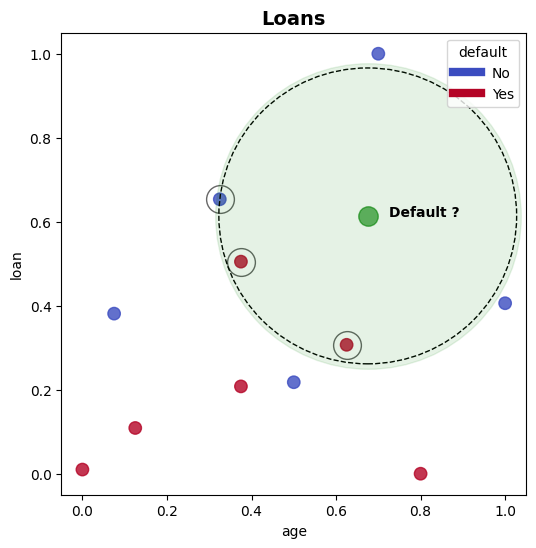

,age,loan,default,distance
2,0.625,0.306931,1,0.310977
4,0.375,0.504950,1,0.319158
10,0.325,0.653465,0,0.352234


In [59]:
dist = DistanceMetric.get_metric('euclidean')
d = dist.pairwise(loans_scaled[['age','loan']],case_scaled[['age','loan']])

loans_scaled['distance'] = d

k3_neighbors_scaled = loans_scaled.nsmallest(3,'distance')

f, ax = plt.subplots(1,1,figsize=(6,6))
cmap_data = plt.cm.coolwarm

ax.plot(case_scaled.age, case_scaled.loan, 'go', markersize=220, alpha=0.10)
ax.scatter(k3_neighbors_scaled.age, k3_neighbors_scaled.loan, edgecolors='k', c='w', alpha=0.6, s=400)
ax.scatter(loans_scaled.age, loans_scaled.loan, c=loans_scaled.default, cmap=cmap_data, alpha=0.8, s=80)
ax.plot(case_scaled.age, case_scaled.loan, 'go', markersize=14, alpha=0.6)

a_circle = plt.Circle((case_scaled.age, case_scaled.loan), k3_neighbors_scaled.distance.max(), edgecolor='k', linestyle='dashed',fill=False)
ax.add_artist(a_circle)

plt.text(case_scaled.age+0.05, case_scaled.loan,'Default ?', weight='bold')
plt.title('Loans',weight='bold',fontsize=14)
plt.xlabel("age")
plt.ylabel("loan")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6)]
plt.legend(custom_lines, ['No', 'Yes'], loc='upper right',title='default')

plt.show()

display(k3_neighbors_scaled)

Como você pode ver o resultado agora é outro e a classe prevista do empréstimo será *Default Yes* (zeros), com probabilidade de $2/3$ e, portanto, deveríamos conceder esse empréstimo.

# Knn `scikit-learn`

Vamos empregar agora o estimador `KNeighborsClassifier` do `scikit-learn` para o mesmo problema acima. O modo de uso do estimador é o mesmo que empregamos para o classificador logístico e será empregado em todos os demais modelos supervisionados que iremos implementar.

In [60]:
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler

X = loans[['age','loan']]
y = loans.default

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
case_scaled = scaler.transform(case)

clf = neighbors.KNeighborsClassifier(n_neighbors = 3)

clf.fit(X, y)

y_pred = clf.predict(case_scaled)

default_pred = ['No','Yes'][y_pred[0]]
print('Default? ', default_pred)

Default?  Yes


## Empregando Valores Categóricos

A distância de vetores de características é uma forma de medirmos similiridade entre os dados e é bastante empregado em uma série de modelos. Atributos categóricos, não numéricos, são muitas vezes muito importantes tendo uma forte influência na predição da classe dos dados, mas o cálculo de uma função distância, como a distância euclidiana que empregamos aqui, requer que os atributos sejam numéricos. A solução, neste caso, é fazermos o *encode* dos dados, transformando-os para numéricos.

Vamos alterar nosso exemplo anterior, incluindo um atributo de duração do empréstimo,  e entender como podemos aplicar o modelo Knn também com atributos categóricos.

In [61]:
loans['Duration'] = ['Short','Long','Short','Undefined','Long','Short','Long','Short','Undefined','Long','Short']

case['Duration'] = ['Short']

display(loans)
display(case)

,age,loan,default,distance,distance_loans,Duration
0,25,40000,1,102000.002373,102000.0,Short
1,35,60000,1,82000.000878,82000.0,Long
2,45,80000,1,62000.000032,62000.0,Short
3,20,20000,1,122000.002988,122000.0,Undefined
4,35,120000,1,22000.003273,22000.0,Long
5,52,18000,1,124000.000101,124000.0,Short
6,23,95000,0,47000.006128,47000.0,Long
7,40,62000,0,80000.000306,80000.0,Short
8,60,100000,0,42000.002012,42000.0,Undefined
9,48,220000,0,78000.000006,78000.0,Long


,age,loan,Duration
0,47,142000,Short


Para transformar o atributo categórico vamos fazer o *hot encode* do atributo `Duration`. Essa técnica consiste em criarmos novos atributos binários (numéricos, 0 ou 1) para cada categoria dos dados e associar o valor 1 para categoria verdadeira.

> *O **Hot Encode** (também Dummy Encode ou ainda One Code) é uma transformação importante e a melhor forma  transformar dados categóricos para numéricos, e preferível a empregar o **Label Encode** (isto é, associar valores ordinais como 0,1,2,3... para cada categoria).*

A função `get_dummies()` do Pandas é um meio simples e bastante comum para fazermos o hot encode de dados.

In [62]:
pd.get_dummies(loans,prefix='Duration')

,age,loan,default,distance,distance_loans,Duration_Long,Duration_Short,Duration_Undefined
0,25,40000,1,102000.002373,102000.0,0,1,0
1,35,60000,1,82000.000878,82000.0,1,0,0
2,45,80000,1,62000.000032,62000.0,0,1,0
3,20,20000,1,122000.002988,122000.0,0,0,1
4,35,120000,1,22000.003273,22000.0,1,0,0
5,52,18000,1,124000.000101,124000.0,0,1,0
6,23,95000,0,47000.006128,47000.0,1,0,0
7,40,62000,0,80000.000306,80000.0,0,1,0
8,60,100000,0,42000.002012,42000.0,0,0,1
9,48,220000,0,78000.000006,78000.0,1,0,0


Mas, novamente como na normalização, o uso de uma função para esse tipo de transformação apresenta dificuldade para a aplicação em novos conjuntos de dados.

In [63]:
pd.get_dummies(case,prefix='Duration')

,age,loan,Duration_Short
0,47,142000,1


É preferível, assim, também empregarmos um estimador neste caso.

In [64]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

hot_encode = OneHotEncoder(handle_unknown='ignore')
hot_encode = hot_encode.fit(loans[['Duration']])

display(hot_encode.categories_)

display( pd.DataFrame(hot_encode.transform(loans[['Duration']] ).toarray(), columns = hot_encode.categories_) )
display( pd.DataFrame(hot_encode.transform(case[['Duration']] ).toarray(), columns = hot_encode.categories_) )


[array(['Long', 'Short', 'Undefined'], dtype=object)]

,Long,Short,Undefined
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
5,0.0,1.0,0.0
6,1.0,0.0,0.0
7,0.0,1.0,0.0
8,0.0,0.0,1.0
9,1.0,0.0,0.0


,Long,Short,Undefined
0,0.0,1.0,0.0


Podemos, então, construir um exemplo completo do uso do modelo Knn para a predição do empréstimo, incluindo a normalização e o hot encode de dados.

In [65]:
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X = loans.drop(columns=['default','distance','distance_loans'])
y = loans.default

hot_encode = OneHotEncoder(handle_unknown='ignore')
hot_encode = hot_encode.fit(X[['Duration']])

X = pd.concat([ X, pd.DataFrame(hot_encode.transform(loans[['Duration']] ).toarray(), columns = list(hot_encode.categories_[0])) ], axis=1 )
X = X.drop(columns=['Duration'])

case = pd.concat([ case, pd.DataFrame(hot_encode.transform(case[['Duration']] ).toarray(), columns = list(hot_encode.categories_[0])) ], axis=1 )
case = case.drop(columns=['Duration'])

display(X)
display(case)

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
case_scaled = scaler.transform(case)

clf = neighbors.KNeighborsClassifier(n_neighbors = 3)

clf.fit(X, y)

y_pred = clf.predict(case_scaled)

default_pred = ['No','Yes'][y_pred[0]]
print('Default? ', default_pred)

,age,loan,Long,Short,Undefined
0,25,40000,0.0,1.0,0.0
1,35,60000,1.0,0.0,0.0
2,45,80000,0.0,1.0,0.0
3,20,20000,0.0,0.0,1.0
4,35,120000,1.0,0.0,0.0
5,52,18000,0.0,1.0,0.0
6,23,95000,1.0,0.0,0.0
7,40,62000,0.0,1.0,0.0
8,60,100000,0.0,0.0,1.0
9,48,220000,1.0,0.0,0.0


,age,loan,Long,Short,Undefined
0,47,142000,0.0,1.0,0.0


Default?  No


# CASO: Breast Cancer biopsy

Este banco de dados de câncer de mama foi obtido dos Hospitais da Universidade de Wisconsin, que avaliou biópsias de tumores de mama em 699 pacientes até 1992;. Cada um dos nove atributos foi pontuado em uma escala de 1 a 10.

Fonte: https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv

Documentação: https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/biopsy.html

In [66]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,class
rownames,,,,,,,,,,,
1,1000025,5,1,1,1,2,1.0,3,1,1,benign
2,1002945,5,4,4,5,7,10.0,3,2,1,benign
3,1015425,3,1,1,1,2,2.0,3,1,1,benign
4,1016277,6,8,8,1,3,4.0,3,7,1,benign
5,1017023,4,1,1,3,2,1.0,3,1,1,benign


## Preparação dos Dados

As variáveis preditoras são todas numéricas e não há, portanto, necessidade do hot encode dos atributos. Há entretanto valores ausentes.

In [67]:
df.isnull().sum() / len(df)

ID       0.00000
V1       0.00000
V2       0.00000
V3       0.00000
V4       0.00000
V5       0.00000
V6       0.02289
V7       0.00000
V8       0.00000
V9       0.00000
class    0.00000
dtype: float64

O percentual é pequeno e poderíamos talvez excluir os dados ausentes, mas vamos optar por fazer o *input* dos dados ausentes pelo valor médio.

In [68]:
df['V6'] = df[['V6']].fillna(df['V6'].mean())
df.isnull().sum() / len(df)

ID       0.0
V1       0.0
V2       0.0
V3       0.0
V4       0.0
V5       0.0
V6       0.0
V7       0.0
V8       0.0
V9       0.0
class    0.0
dtype: float64

## Aplicando o Modelo Knn

No nosso exemplo anterior, não fizemos separação de conjuntos de treinamento e teste, afinal era um exemplo simples apenas para entendermos os princípios do modelo.

Vamos agora implementar o modelo empregando o esquema mais geral de aprendizado supervisionado incluindo o uso dos conjuntos de treinamento e teste, e as avaliações do modelo.

In [69]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X = df.drop(columns=['ID','class'])
y = df['class']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

clf = neighbors.KNeighborsClassifier(n_neighbors = 3)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print( y_pred[0:10], '...' )
print( clf.score(X,y) )

['benign' 'benign' 'malignant' 'benign' 'benign' 'malignant' 'benign'
 'benign' 'benign' 'benign'] ...
0.9699570815450643


> **Nota Técnica:** *Normalizar com `X` ou `X_train`*

> A rigor, como os dados de teste simulam *casos novos*, não teríamos acesso a esses dados no momento do treinamento e, portanto, para a normalização dos dados empregando todos os dados (`X`), mas apenas os dados de Treinamento (`X_train`). Assim, é mais correto e metodologicamente mais adequado, construir o estimador somente sobre os dados de treinamento (`X_train`) e, então, aplicar esse estimador aos demais dados (`X_test`, e se for o caso `X`). Isso evita *vazarmos* informações do conjunto de teste para o treinamento e *será sempre a melhor prática*.

> Para você entender, `X_test` por exemplo, poderia ter um valor de um atributo maior que qualquer atributo de `X_train`, e esse valor influenciaria na normalização quando empregado o `X` (`X_test` + `X_train`). Veja o exemplo numérico abaixo com uma normalização `MinMax()` (feita manualmente dividindo os dados pelo maior valor).

In [70]:
#@markdown You can skip this code
np.set_printoptions(precision=2)

X = np.array([1, 2, 3])
X_train = np.array([1, 2])
X_test = np.array([3])

print('Dados Originais:')
print(60*'-' + '\n')
print('X       = ', X)
print('X_train = ', X_train)
print('X_test  = ', X_test)
print()

X = np.array([1/3, 2/3, 3/3]) # X = X / X.max()
X_train = np.array([1/3, 2/3])
X_test = np.array([3/3])

print('Normalização (MinMax) a partir de X:')
print(60*'-' + '\n')
print('X       = ', X)
print('X_train = ', X_train)
print('X_test  = ', X_test)
print()

X_train = np.array([1/2, 2/2]) # X_train = X_train / X_train.max()
X = np.array([1/2, 2/2, 3/2])
X_test = np.array([3/2])

print('Normalização (MinMax) a partir de X_train:')
print(60*'-' + '\n')
print('X       = ', X)
print('X_train = ', X_train)
print('X_test  = ', X_test)
print()

np.set_printoptions(precision=8) # restor default


Dados Originais:
------------------------------------------------------------

X       =  [1 2 3]
X_train =  [1 2]
X_test  =  [3]

Normalização (MinMax) a partir de X:
------------------------------------------------------------

X       =  [0.33 0.67 1.  ]
X_train =  [0.33 0.67]
X_test  =  [1.]

Normalização (MinMax) a partir de X_train:
------------------------------------------------------------

X       =  [0.5 1.  1.5]
X_train =  [0.5 1. ]
X_test  =  [1.5]



> Para os nossos conjuntos de dados aqui essa diferença bastante pouco influência. Você pode observar no código abaixo, onde aplicamos a melhor prática, e o resultado é o mesmo. Mas para grandes conjuntos de dados e aplicações profissionais é mais adequado aplicar essa prática. Ao longo do texto, entretanto, por ter pouca ou nenhuma influência nos nossos resultados e por simplificar bastante os exemplos dados, adotaremos a normalização com base no conjunto completo de dados como acima na maior parte do tempo, o que é simplificação comum à maior parte das publicações didáticas na área.

In [71]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X = df.drop(columns=['ID','class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

scaler = MinMaxScaler()
scaler.fit(X_train)
X, X_train, X_test = scaler.transform(X), scaler.transform(X_train), scaler.transform(X_test)

clf = neighbors.KNeighborsClassifier(n_neighbors = 3)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print( y_pred[0:10], '...' )
print( clf.score(X,y) )

['benign' 'benign' 'malignant' 'benign' 'benign' 'malignant' 'benign'
 'benign' 'benign' 'benign'] ...
0.9699570815450643


## Predição de Novos Casos

Se considerarmos 0.96 um bom resultado podemos então aplicar o modelo para novos casos. Por exemplo, podemos fazer predição considerando pacientes hipotéticos valores das medidas v1-v9 dos tumores nos percentis  $[0.10, 0.25, 0.75, 0.90]$.

In [72]:
X_new = pd.DataFrame( df.drop(columns=['ID','class']).quantile([0.10, 0.25, 0.75, 0.90]) ).reset_index(drop=True)
display(X_new)
X_new_scaled = scaler.transform(X_new)

,V1,V2,V3,V4,V5,V6,V7,V8,V9
0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
1,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0
2,6.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,1.0
3,9.0,9.0,8.0,8.0,6.0,10.0,7.0,9.0,3.0


In [73]:
clf.predict(X_new_scaled)

array(['benign', 'benign', 'malignant', 'malignant'], dtype=object)

In [74]:
X_new['predicted'] = clf.predict(X_new_scaled)
X_new

,V1,V2,V3,V4,V5,V6,V7,V8,V9,predicted
0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,benign
1,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,benign
2,6.0,5.0,5.0,4.0,4.0,5.0,5.0,4.0,1.0,malignant
3,9.0,9.0,8.0,8.0,6.0,10.0,7.0,9.0,3.0,malignant


# Métricas de Distância

Para medir a distância entre vetores característicos empregamos até aqui a distância Euclidiana. Ela é a distância mais comum, mas existem várias funções distância que podem ser aplicadas, não só aqui mas também em outros modelos (*knn*, *kmeans* etc.). Embora a distância euclidiana pareça ser a mais aplicada, outras funções distância encontram mais uso em contextos específicos como a distância de **Hamming** para dados binários e cadeias de strings ou a distância **Coseno** para análise de dados de linguagem natural, textos e documentos.

Uma função é uma função distância se atende 4 propriedades:

$i. d(x,y) \ge 0$

$ii. d(x,x) = 0$

$iii. d(x,y) = d(y,x)$

$iv.  d(x,y) \le d(x,z) + d(z,y)$



## Algumas funções distância comuns

Distância Euclidiana $\qquad \qquad \qquad \qquad \qquad \qquad$ ${\displaystyle \| ab \| _ {2} = {\sqrt {\sum _ {i} (a_ {i} -b_ {i}) ^ {2}}}}$

Distância Euclidiana Quadrática $\qquad \qquad \qquad \qquad$  ${\displaystyle \| ab \| _ {2} ^ {2} = \sum _ {i} (a_ {i} -b_ {i}) ^ {2}} $

Distância de Manhattan $\qquad \qquad \qquad\qquad \qquad$ ${\displaystyle \| ab \| _ {1} = \sum _ {i} | a_ {i} -b_ {i} |}$

Distância Máxima $\qquad \qquad \qquad \qquad \qquad\qquad$  ${\displaystyle \| ab \| _ {\infty} = \max _ {i} | a_ {i} -b_ {i} |}$

Distância Minkowski $\qquad \qquad \qquad \qquad \qquad \qquad$ ${\displaystyle \| ab \| _ {Minkowski} = {(\sum _ {i} |a_ {i} -b_ {i}| ^ {p}})^{\frac{1}{p}}}$







### Distância de Hamming para Strings

A distância de Hamming tem aplicação para cadeias de símbolos de mesmo comprimento e, por exemplo, pode ser empregada para medir a distância entre cadeias de DNA.





In [75]:
def hamming_distance(string1, string2):
	dist_counter = 0
	for n in range(len(string1)):
		if string1[n] != string2[n]:
			dist_counter += 1
	return dist_counter

hamming_distance('ACGTACGT','ACGTTACG')

4

In [76]:
def hamming_distance2(string1, string2):
  return sum(xi != yi for xi, yi in zip(string1, string2))

hamming_distance2('ACGTACGT','ACGTTACG')

4

### Distância Cosseno

A Distância Cosseno encontra aplicação no tratamento de  textos em que os textos têm uma representação vetorial baseada na frequência dos termos (ou palavras) como as representações *bow*, *tf-idf* etc. Ela mede o ângulo formado pelos vetores e a distância de dois vetores $a$ e $b$ pode ser obtida a partir da expressão:

$$ a b^t  = \|a\| \|b\| cos(\theta)$$

Definimos a *similaridade* de dois vetores como:

$$ similarity(a,b) = cos(\theta) = \frac{a b^t }{\|a\| \|b\|} = \frac{ \sum\limits_{i=1}^{n}{a_i  b_i} }{ \sqrt{\sum\limits_{i=1}^{n}{a_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{b_i^2}} }$$

E a distância:

$$ distance(a,b) = 1 - similarity(a,b)$$


O exemplo a seguir ilustra o uso dessa forma de distância para a busca de documentos similares e compara os resultados com o uso da distância euclidiana.

In [77]:
# apenas como empregar as funções cosine_similarity e cosine_distances
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

print( cosine_similarity([[0,1,1]],[[0,2,2]]) )
print( cosine_distances([[0,1,1]],[[0,2,2]]) )


[[1.]]
[[2.22044605e-16]]


Textos com representação vetorial BOW (Bag of Words), o valor na matriz sendo a quantidade de vezes que o termo aparece no documento

In [78]:

dfd = pd.read_excel('http://meusite.mackenzie.br/rogerio/FCI22020/TFIDFExample2.xlsx',
                    skiprows=range(0,3),nrows=10,index_col=0,usecols=range(0,2),header=None).reset_index()
dfd.columns = ['tf(i,j)','Text']
df = pd.read_excel('http://meusite.mackenzie.br/rogerio/FCI22020/TFIDFExample2.xlsx',
                   skiprows=range(0,16),nrows=9,index_col=0,usecols=range(0,14))
df[['Text']] = dfd[['Text']]
display(df)

,"tf(i,j)",system,user,graph,trees,response,EPS,interface,human,survey,computer,minors,time,Text
1,d1,0,0,0,0,0,0,1,1,0,1,0,0,Human machine interface for ABC computer appli...
2,d2,1,1,0,0,1,0,0,0,1,1,0,1,A survey of user opinion of computer system re...
3,d3,1,1,0,0,0,1,1,0,0,0,0,0,The EPS user interface management system.
4,d4,2,0,0,0,0,1,0,1,0,0,0,0,System and human system engineering testing in...
5,d5,0,1,0,0,1,0,0,0,0,0,0,1,Relation to user perceived response time to er...
6,d6,0,0,0,1,0,0,0,0,0,0,0,0,"The generation of random, binary, ordered trees."
7,d7,0,0,1,1,0,0,0,0,0,0,0,0,The intersection graph of paths in trees.
8,d8,0,0,1,1,0,0,0,0,0,0,1,0,Graph minors IV: Widths of trees and well-quas...
9,d9,0,0,1,0,0,0,0,0,1,0,1,0,Graph minors: A survey.


Abaixo, as distâncias coseno e euclidiana dos documentos.

In [79]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

docs = df.drop(columns=['tf(i,j)','Text'])
doc = df[df['tf(i,j)'] == 'd1'].drop(columns=['tf(i,j)','Text'])

print( cosine_distances(docs, doc) )

[[0.        ]
 [0.76429774]
 [0.71132487]
 [0.76429774]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]


In [80]:
dist = DistanceMetric.get_metric('euclidean')
print( dist.pairwise(docs, doc) )

[[0.        ]
 [2.64575131]
 [2.23606798]
 [2.64575131]
 [2.44948974]
 [2.        ]
 [2.23606798]
 [2.44948974]
 [2.44948974]]


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


> Embora não possamos desenvolver aqui os vários tópicos que envolvem o processamento de textos e de linguagem natural, o exemplo acima permite entender que podemos aplicar as mesmas técnicas de aprendizado supervisionado que aplicamos até aqui em dados tabulares, em textos e documentos a partir de uma representação vetorial desses elementos (e o mesmo é válido para outros modelos). Em outros termos, podemos aplicar técnicas como Knn, Regressão Logística, e mesmo outras que veremos a seguir, para classificar também documentos, e-mails ou páginas de um site.

# Seleção de Hiperparâmetros

Em todos exemplos anteriores empregamos o modelo Knn com k=3 e a função de distância euclidiana. Será que haveriam *hiperparâmetros* melhores com desempenho melhor?

A escolha de melhores *hiperparâmetros* é em geral por experimentação uma vez que não existem hiperparâmetros melhores *apriori* para quaisquer conjuntos de dados. A ideia, então, é criarmos os diferentes modelos e avaliarmos o desempenho de cada um para obtermos os melhores hiperparâmetros.

Podemos então adaptar o nosso código do modelo Knn anterior para, por exemplo, variar os hiperparâmetros k, no range de valores de 2 a 10 e experimentar o resultado das funções distância 'euclidean' e 'manhattan'. manhattan

In [81]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df['V6'] = df[['V6']].fillna(df['V6'].mean())

X = df.drop(columns=['ID','class'])
y = df['class']

scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

for k, d in [(k,d) for k in range(2,11) for d in ['euclidean','manhattan']]:

  clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= d )

  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  print( k, d, np.round( clf.score(X_test,y_test), 4) )

2 euclidean 0.9095
2 manhattan 0.9286
3 euclidean 0.9429
3 manhattan 0.9381
4 euclidean 0.9381
4 manhattan 0.9333
5 euclidean 0.9429
5 manhattan 0.9333
6 euclidean 0.9381
6 manhattan 0.9286
7 euclidean 0.9429
7 manhattan 0.9333
8 euclidean 0.9381
8 manhattan 0.9333
9 euclidean 0.9381
9 manhattan 0.9381
10 euclidean 0.9381
10 manhattan 0.9429


Embora tendo escolhido os conjuntos de treinamento e teste de forma aleatória o resultado acima, pode depender do par (treinamento, teste) escolhido. Para não considerarmos o resultado de uma única amostra, podemos fazer várias execuções a obter a média dos valores sobre várias amostras, o que será uma medida dependente de um par específico de dados e uma melhor aproximação do resultado esperado do modelo.

In [82]:
scores_means = {}

for k, d in [(k,d) for k in range(2,9) for d in ['euclidean','manhattan']]:

  scores = []
  for i in range(0,25):

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

    clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= d )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    scores.append(clf.score(X_test,y_test))

  scores_means[(k,d)] = np.mean(scores)

scores_means = pd.DataFrame(scores_means.values(), index=scores_means.keys()).reset_index()
scores_means.columns = ['k','metric','score']

display(scores_means)
print('\nBest result:\n')
display(scores_means.nlargest(1,'score'))

,k,metric,score
0,2,euclidean,0.909524
1,2,manhattan,0.928571
2,3,euclidean,0.942857
3,3,manhattan,0.938095
4,4,euclidean,0.938095
5,4,manhattan,0.933333
6,5,euclidean,0.942857
7,5,manhattan,0.933333
8,6,euclidean,0.938095
9,6,manhattan,0.928571



Best result:



,k,metric,score
2,3,euclidean,0.942857


Desse modo, concluímos que para o nosso conjunto de dados os melhores resultados com o modelo knn são obtidos com os parâmetros acima.

# Conjuntos de Validação e Teste

Ao avaliar diferentes hiperparâmetros para os estimadores, como o valor de k e a métrica do estimador `KNeighborsClassifier`, traz entretanto o risco de overfitting no conjunto de teste, porque os hiperparâmetros podem ser ajustados *até que* o estimador tenha o desempenho ideal e, do mesmo modo que antes para o conjunto de treinamento, o conhecimento sobre o conjunto de teste pode *vazar* para o modelo e as métricas de avaliação mascarando o desempenho de generalização do modelo.

Deveríamos assim separar novamente uma outra parte do conjunto de dados, um *conjunto de validação* que seria empregado para validar o modelo durante a seleção dos hiperparâmetros: o treinamento, com diferentes hiperparâmetros,  continua no conjunto de treinamento; em seguida a avaliação é feita no conjunto de validação; após os experimentos sucedidos, a avaliação final pode ser feita no conjunto de teste.

A implementação do nosso modelo seria então a seguinte:




In [83]:
scores_means = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

for k, d in [(k,d) for k in range(2,9) for d in ['euclidean','manhattan']]:

  scores = []
  for i in range(0,25):

    X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=123)

    clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= d )

    clf.fit(X_train_val, y_train_val)

    y_pred = clf.predict(X_val)

    scores.append(clf.score(X_val,y_val))

  scores_means[(k,d)] = np.mean(scores)

scores_means = pd.DataFrame(scores_means.values(), index=scores_means.keys()).reset_index()
scores_means.columns = ['k','metric','score']

display(scores_means)
print('\nBest result:\n')
display(scores_means.nlargest(1,'score'))



,k,metric,score
0,2,euclidean,0.928571
1,2,manhattan,0.948980
2,3,euclidean,0.948980
3,3,manhattan,0.948980
4,4,euclidean,0.948980
5,4,manhattan,0.938776
6,5,euclidean,0.959184
7,5,manhattan,0.959184
8,6,euclidean,0.959184
9,6,manhattan,0.959184



Best result:



,k,metric,score
6,5,euclidean,0.959184


E podemos agora verificar o resultado desse melhor modelo no conjunto de teste para a avaliação final.

In [84]:
k = scores_means.nlargest(1,'score').k.values[0]
metric = scores_means.nlargest(1,'score').metric.values[0]

clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= metric )
print(clf)

clf.fit(X_train, y_train)

print("accuracy: %0.3f" % clf.score(X_test,y_test),'\n')



KNeighborsClassifier(metric='euclidean')
accuracy: 0.943 



Esperamos com esse modelo obter um resultado de 0.93 de acuracidade e esse é um valor metodologicamente mais correto que as estimativas anteriores.

# Cross Validation

Mas ao particionar os dados disponíveis em três conjuntos, reduzimos drasticamente o número de amostras que podem ser usadas para aprender o modelo.

Uma solução para este problema, e também para buscarmos um resultado menos dependente de uma escolha aleatória particular do par (treino, validação), é uma técnica denominada validação cruzada ou cross validation (CV). Um conjunto de teste ainda deve ser apresentado para avaliação final, mas o conjunto de validação não é mais necessário ao empregar o CV. Em sua forma mais simples, denominada *k-fold CV*, o conjunto de treinamento é dividido em k partições aleatórias menores e o treinamento ocorre do seguinte modo:

> Para as $k$ partições:

> 1. O modelo é treinado empregando-se $k-1$ partições dos dados de treinamento;

> 2. O modelo resultante é validado na parte restante dos dados, isto é, é usado como conjunto de teste para calcular a métrica de desempenho, por exemplo a acuracidade ou a precisão.

A medida de desempenho do CV é, então, a média dos valores calculados para as $k$ medidas. Embora computacionalmente cara, o CV não desperdiça e é um procedimento mais sistemático que garante que todos os dados serão testados pelo modelo em algum momento.

<br>

<br>

![imagem](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

<small>
<b>
Figura 1. Esquema de Cross-Validation. <br></b>  (Fonte: https://scikit-learn.org)

O `scikit-learn` implementa diferentes tipos de CV que variam basicamente na forma com são selecionadas as partições. O `KFold` e o `StratifiedKFold` são as formas mais comuns e suas partições são exemplificadas abaixo.

In [85]:
# you can skip this code!

# Código livremente adaptado de: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
#
cmap_data = plt.cm.viridis
cmap_cv = plt.cm.binary

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    custom_lines = [Line2D([0], [0], color=cmap_cv(0.2), lw=6),
                Line2D([0], [0], color=cmap_cv(0.8), lw=6)]
    ax.legend(custom_lines, ['Train', 'Test'], loc='upper right')

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["", "class"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax



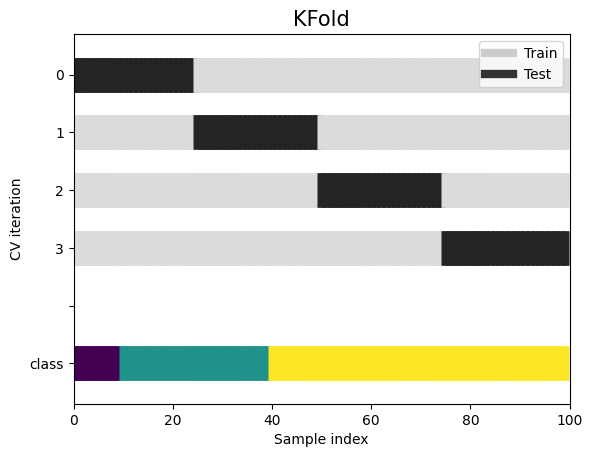

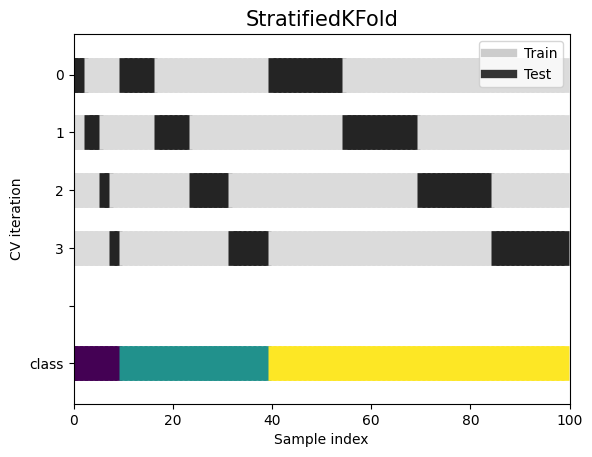

In [86]:
# you can skip this code!

from sklearn.model_selection import KFold, StratifiedKFold
np.random.seed(1338)

n_splits = 4

n_points = 100
X = np.random.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
groups = np.hstack([[ii] * 10 for ii in range(10)])

fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)
plt.show()

fig, ax = plt.subplots()
cv = StratifiedKFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)
plt.show()

Note que as faixas correspodem a índices aleatórios e não dados contíguos.

## Aplicando o CV

A forma mais simples de empregar o CV é aplicar a função `cross_val_score()` sobre o estimador e o conjunto de dados. Ela por padrão irá retornar o *score* do estimador em uma estratégia de `StratifiedKFold`, mas outras métricas podem ser obtidas.

In [87]:
from sklearn.model_selection import cross_val_score

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df['V6'] = df[['V6']].fillna(df['V6'].mean())

X = df.drop(columns=['ID','class'])
y = df['class']

scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

clf = neighbors.KNeighborsClassifier(n_neighbors = 3, metric= 'euclidean' )

acc_scores = cross_val_score(clf, X_train, y_train, cv = 10)

print(acc_scores, '\n')
print("accuracy: %0.3f +/- %0.3f" % (acc_scores.mean(), acc_scores.std() * 2),'\n')

for metric in ['accuracy','f1_macro','precision_macro','recall_macro']:
  scores = cross_val_score(clf, X_train, y_train, cv = 4, scoring=metric)
  print(metric + ": %0.3f +/- %0.3f" % (scores.mean(), scores.std() * 2))




[0.97959184 0.93877551 1.         0.97959184 0.95918367 0.95918367
 1.         0.93877551 0.97959184 0.95833333] 

accuracy: 0.969 +/- 0.042 

accuracy: 0.971 +/- 0.008
f1_macro: 0.968 +/- 0.009
precision_macro: 0.970 +/- 0.009
recall_macro: 0.967 +/- 0.018


Aplicando agora o `cross_val_score()` ao nosso exemplo na busca de melhores hiperparâmetros você pode obter:

In [88]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df['V6'] = df[['V6']].fillna(df['V6'].mean())

X = df.drop(columns=['ID','class'])
y = df['class']

scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

scores_means = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

for k, d in [(k,d) for k in range(2,9) for d in ['euclidean','manhattan']]:

  clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= d )

  acc_scores = cross_val_score(clf, X_train, y_train, cv = 5)

  scores_means[(k,d)] = acc_scores.mean()

scores_means = pd.DataFrame(scores_means.values(), index=scores_means.keys()).reset_index()
scores_means.columns = ['k','metric','score']

# display(scores_means)
print('\nBest result:\n')
display(scores_means.nlargest(1,'score'))



Best result:



,k,metric,score
7,5,manhattan,0.975489


E pode agora aplicar o melhor modelo obtido:

In [89]:
k = scores_means.nlargest(1,'score').k.values[0]
metric = scores_means.nlargest(1,'score').metric.values[0]

clf = neighbors.KNeighborsClassifier(n_neighbors = k, metric= metric )
print(clf)

clf.fit(X_train, y_train)

print("accuracy: %0.3f" % clf.score(X_test,y_test),'\n')

KNeighborsClassifier(metric='manhattan')
accuracy: 0.933 



Você deve notar que esse procedimento, variando hiperparâmetros do estimador, poderia ser igualmente empregado para avaliar e selecionar diferentes estimadores e você, por exemplo, poderia alterar o código acima para avaliar o desempenho dos estimadores `KNeighborsClassifier` e `LogisticRegression` a fim de escolher o melhor classificador.

# Usando o Grid Search

O último refinamento que faremos no procedimento de busca de melhores hiperparâmetros consiste em empregarmos `GridSearchCV()` do `scikit-learn`. Essa função automatiza a busca de melhores hiperparâmetros que fizemos acima implementando de forma manual os diferentes estimadores para um espaço de hiperparâmetros em `for k, d in [(k,d) for k in range(2,9) for d in ['euclidean','manhattan']]:...` e podendo ser aplicada a qualquer estimador.

Qualquer parâmetro de um estimador pode ser otimizado desta maneira e para encontrar os nomes e valores dos parâmetros de um determinado estimador você pode empregar o método `estimator.get_params()`.




In [90]:
clf = neighbors.KNeighborsClassifier()
clf.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier()>

e do mesmo modo os hiperparâmetros da regressão logística podem também ser obtidos:

In [91]:
# e do mesmo modo os hiperparâmetros da regressão logística são também obtidos
from sklearn.linear_model import LogisticRegression
LogisticRegression().get_params

<bound method BaseEstimator.get_params of LogisticRegression()>

Duas abordagens para a pesquisa de hiperparâmetros são fornecidas no `scikit-learn` para os valores fornecedos pelo usuário. O `GridSearchCV` considera exaustivamente todas as combinações de parâmetros e o `RandomizedSearchCV` emprega uma amostra de candidatos de um espaço de hiperparâmetros com uma distribuição específica. Nos dois casos a aplicação é bastante direta e a função apenas precisa receber o classificador, os valores dos hiperparâmetros desejados e o CV a ser empregado.



In [92]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv',index_col=0)
df['V6'] = df[['V6']].fillna(df['V6'].mean())

X = df.drop(columns=['ID','class'])
y = df['class']

scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

base_estimator = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': [3,4,5,6,7,8,9,10], 'metric': ['euclidean','manhattan']}

clf = GridSearchCV(base_estimator, param_grid, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

# print(clf.cv_results_)
print(clf.best_estimator_)

print()
print("Detailed classification report:")
print()
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print()



KNeighborsClassifier(metric='manhattan')

Detailed classification report:

              precision    recall  f1-score   support

      benign       0.94      0.96      0.95       138
   malignant       0.91      0.89      0.90        72

    accuracy                           0.93       210
   macro avg       0.93      0.92      0.93       210
weighted avg       0.93      0.93      0.93       210




Por padrão as funções de pesquisa em grade, como o `GridSearchCV()` empregam o `score` padrão do estimador como função de pontuação (no caso de classificação é o `accuracy`), mas deixamos explícito o parâmetro pois você poderia querer empregar uma função de pontuação dos estimadores baseada em outra métrica.

Sendo o formato final do nosso procedimento também substituímos no código acima a exibição final do `score` que vínhamos empregando pelo `classification_report` que exibe um resultado mais completo do modelo selecionado.

Em resumo, nosso procedimento de pesquisa de melhores hiperparâmetros de um estimador consiste em:

1. Selecionar um estimador (um classificador ou um regressor)
2. Definir um espaço de hiperparâmetros que desejamos avaliar
3. Definir uma função de pontuação (*score function*)
4. Empregar um esquema de validação cruzada





<br>

<br>

![imagem](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

<small>
<b>
Figura 2. Esquema Geral da Avaliação de Modelos. <br></b>  (Fonte: https://scikit-learn.org)



# Síntese

Nesta trilha você aprendeu a empregar o modelo de KVizinhos mais Próximos para classificação. A partir de um problema inicial bastante simples e uma solução do zero você pode conhecer os princípios desse modelo. Em seguida, em uma sequência de passos, incrementamos nosso modelo para que você pudesse compreender vários conceito e técnicas importantes que podem ser aplicadas a estimadores e análises em geral:

* Na preparação dos dados
  * Normalização de Dados empregando estimadores
  * Encode de Dados empregando estimadores

* No desenvolvimento e avaliação dos modelos
  * Conjuntos de Validação e Teste
  * Validação Cruzada
  * Pesquisa em Grade para seleção de hiperparâmetros

Todos esses procedimentos, que aplicamos para o estimador específico do Knn, podem ser igualmente aplicados a quaisquer estimadores e o procedimento final dessa trilha fornece um modelo de código que você irá empregar em outros estimadores adiante.

# Para Saber Mais

* A documentação do `scikit-learn` é uma excelente fonte de consulta para todos as técnicas que empregamos aqui. Mas ela é também bastante extensa e selecionamos aqui alguns dos links principais que podem interessar:

  * **Cross-validation: evaluating estimator performance**, Disponível em: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
  * **Tuning the hyper-parameters of an estimator**, Disponível em: https://scikit-learn.org/stable/modules/grid_search.html#grid-search
  * **Parameter estimation using grid search with cross-validation**, Disponível em: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

* Mas para saber mais sobre esses procedimentos o melhor mesmo é praticar. Você pode empregar então o último código dessa trilha, que é um modelo final de código para seleção de hiperparâmetros de um classficador, para fazer o mesmo para o classificador logístico, um regressor linear ou ainda empregar um outro conjunto de dados de seu interesse. Essas são atividades que, de fato, irão ajudá-lo a saber mais sobre o que tratamos aqui.

* De um modo simples, dados são normalizados ou redimensionados para trazer todas as variáveis ​​em proporção umas com as outras. Existem diferentes formas de normalização e redimensionamento de dados e aqui aplicamos apenas uma delas. Acesse o artigo **When to perform a Feature Scaling?** de Raghav Vashisht, disponível em: https://www.atoti.io/when-to-perform-a-feature-scaling/ para saber mais sobre isso e veja também **Compare the effect of different scalers on data with outliers** disponível em: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html para conhecer outros estimadores de normalização do `scikit-learn`.






# Referências

Sayad, Saed (2021). **An Introduction to Data Science**,
Disponível em: https://www.saedsayad.com/data_mining_map.htm Acesso: 12 de Novembro de 2021.

Subasi, A. (2020). **Machine learning techniques. Practical Machine Learning for Data Analysis Using Python**, 91–202. doi:10.1016/b978-0-12-821379-7.00003-5

Larose, Chantal D.; Larose, Daniel T. **Data Science Using Python and R** Hoboken: Wiley, c2019. E-book (259 p.) (Wiley Series on Methods and Applications in Data Mining Ser.). ISBN 9781119526834 (electronic bk.). Disponível em: https://www3.mackenzie.br/biblioteca_virtual/index.php?tipoBiblio=ebookcentral&flashObg=n

Kotu, Vijay; Deshpande, Balachandre **Data Science: concepts and practice**. 2nd ed. Cambridge, [England]: Morgan Kaufmann, c2019. E-book (570 p.) ISBN 9780128147627 (electronic bk.). Disponível em: http://pergamum.mackenzie.br:8080/pergamumweb/vinculos/00003c/00003cef.jpg.

Jake VanderPlas. **Python Data Science Handbook**  O'Reilly Media, Inc. (2016). ISBN: 9781491912058. Disponível em: https://jakevdp.github.io/PythonDataScienceHandbook/. Acesso: 06 de Novembro de 2021.

___. **Cross-validation: evaluating estimator performance**, Disponível em: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation Acesso em: 13 de Novembro de 2021.

___.  **Tuning the hyper-parameters of an estimator**, Disponível em: https://scikit-learn.org/stable/modules/grid_search.html#grid-search Acesso em: 13 de Novembro de 2021.

___. **Parameter estimation using grid search with cross-validation**, Disponível em: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py Acesso em: 13 de Novembro de 2021.